In [9]:
import os, pickle, sys
if ".." not in sys.path:
    sys.path.insert(0, "..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

import utils_txt as tut

In [3]:
with open('alexnet_acts.pkl', 'rb') as f:
    acts = pickle.load(f)
    
for layer, out in acts.items():
    print(f'{layer:<15} | {str(out.shape):>35}')

features.0      |      torch.Size([1072, 64, 55, 55])
features.1      |      torch.Size([1072, 64, 55, 55])
features.2      |      torch.Size([1072, 64, 27, 27])
features.3      |     torch.Size([1072, 192, 27, 27])
features.4      |     torch.Size([1072, 192, 27, 27])
features.5      |     torch.Size([1072, 192, 13, 13])
features.6      |     torch.Size([1072, 384, 13, 13])
features.7      |     torch.Size([1072, 384, 13, 13])
features.8      |     torch.Size([1072, 256, 13, 13])
features.9      |     torch.Size([1072, 256, 13, 13])
features.10     |     torch.Size([1072, 256, 13, 13])
features.11     |     torch.Size([1072, 256, 13, 13])
features.12     |       torch.Size([1072, 256, 6, 6])
features        |       torch.Size([1072, 256, 6, 6])
avgpool         |       torch.Size([1072, 256, 6, 6])
classifier.0    |            torch.Size([1072, 9216])
classifier.1    |            torch.Size([1072, 4096])
classifier.2    |            torch.Size([1072, 4096])
classifier.3    |           

=========== linear layer ==================
variance explained by first 50 pcs: 0.498
variance explained by first 2 pcs:  0.083

=========== relu layer ==================
variance explained by first 50 pcs: 0.498
variance explained by first 2 pcs:  0.083



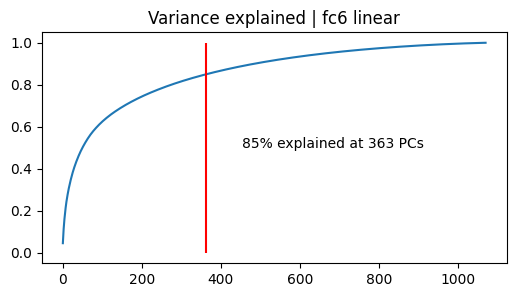

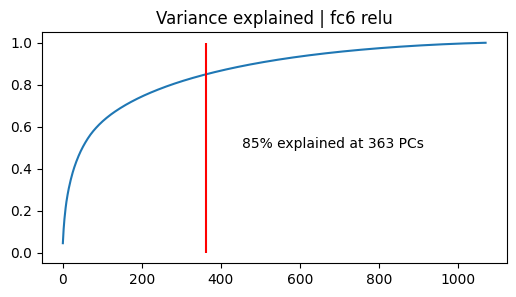

In [4]:
## PCA following Bao et al. 2020
## They get 85% variance at first 50 PCs...i need 363

# these are the exact same embeddings...
fc6 = {}
fc6['linear'] = acts['classifier.1'].detach().cpu().numpy()
fc6['relu'] = acts['classifier.2'].detach().cpu().numpy()

for layer, X in fc6.items():
    print(f'=========== {layer} layer ==================')
    # center across images (critical; sklearn does this internally, but be explicit)
    X = X - X.mean(axis=0, keepdims=True)
    n_img, n_units = X.shape

    # pca over images
    pca = PCA(n_components=min(n_img - 1, n_units), svd_solver='full')
    X_pca = pca.fit_transform(X)          # [n_img, n_img - 1]
    pcs = pca.components_                 # [n_img - 1, n_units]

    # retain first 50 pcs
    k = 50
    X_50 = X_pca[:, :k]                    # image coordinates in reduced space
    pcs_50 = pcs[:k]                       # [50, 4096]
    threshold = 0.85

    # variance explained
    var_explained = pca.explained_variance_ratio_
    var_50 = var_explained[:k].sum()
    var_2 = var_explained[:2].sum()
    cum_var = np.cumsum(var_explained)
    var_thresh = np.where(cum_var>threshold)[0][0]

    print(f'variance explained by first 50 pcs: {var_50:.3f}')
    print(f'variance explained by first 2 pcs:  {var_2:.3f}\n')
    
    fig, ax = plt.subplots(1,1, figsize=(6, 3))
    sns.lineplot(cum_var, ax=ax)
    ax.set_title(f'Variance explained | fc6 {layer}')
    ax.vlines(var_thresh, 0, 1, color='red')
    ax.text(x=var_thresh*1.25, y=0.5, s=f'{int(threshold*100)}% explained at {var_thresh} PCs')

pc1+pc2 variance (72-set): 0.293


Text(0.5, 1.0, 'All images in localizer space')

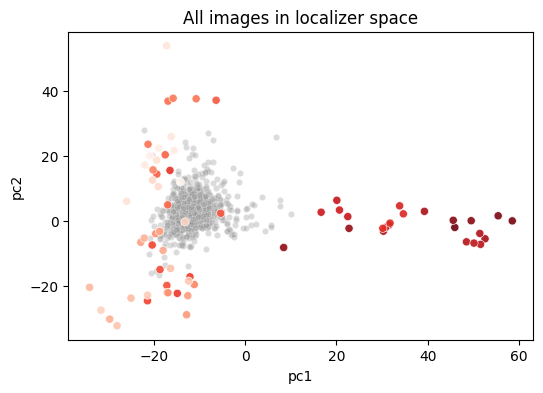

In [21]:
## MAYBE try just the localizer images?

# fc6: torch tensor [1072, 4096], post-relu
X = fc6['linear']

##### z-score the data (based on all images)
mu = X.mean(axis=0, keepdims=True)          # per-unit mean
sd = X.std(axis=0, keepdims=True, ddof=1)   # per-unit std (unbiased)

Xz = (X - mu) / (sd + 1e-8)

# split 
X72 = Xz[1000:]          # basis-defining set
Xall = Xz              # everything to project

# fit pca on last 72 only
pca = PCA(n_components=2, svd_solver='full')
pca.fit(X72)

# project all images into that space
Zall = pca.transform(Xall)    # [1072, 2]
Z72  = Zall[1000:]              # same points, highlighted

######### move to dataframe for plotting
# assume Zall is [1072, 2]
n = Zall.shape[0]
idx = np.arange(n)
is_localizer = idx >= 1000

Zdf = pd.DataFrame({
    'pc1': Zall[:, 0],
    'pc2': Zall[:, 1],
    'is_localizer': is_localizer,
    'localizer_rank': np.where(is_localizer, idx - 1000, np.nan),  # 0..71 for last 72
})

print(f'pc1+pc2 variance (72-set): {pca.explained_variance_ratio_.sum():.3f}')

# plot
fig,ax = plt.subplots(1,1, figsize=(6,4))
customp = sns.color_palette('Reds_r', len(Z72))

# background: all non-localizer images
sns.scatterplot(
    data=Zdf[~Zdf['is_localizer']],
    x='pc1', y='pc2',
    color='0.6', alpha=0.35, s=20,
    ax=ax, legend=False
)

# foreground: last 72 with gradient by rank
sns.scatterplot(
    data=Zdf[Zdf['is_localizer']],
    x='pc1', y='pc2',
    hue='localizer_rank',
    palette=customp,
    alpha=0.9, s=35,
    ax=ax
)
ax.legend().remove()
ax.set_title('All images in localizer space')

In [6]:
DATA_DIR = '../../datasets/NNN/'
dat = pd.read_pickle(os.path.join(DATA_DIR, ('face_roi_data.pkl')))
print(f'Unique face ROIs: {list(dat['roi'].unique())}')
ROI_LIST = dat['roi'].unique()

all_ks = {}
for _r in ['face', 'body', 'object']:
    subdir = os.path.join(DATA_DIR, f'{_r}_mins.pkl')
    df = pd.read_pickle(subdir)
    all_ks.update(df)

Unique face ROIs: ['Unknown_19_F', 'MF1_9_F', 'MF1_8_F', 'AF3_18_F', 'MF1_7_F', 'Unknown_5_F', 'AMC3_28_F']


Unknown_19_F top images: [ 559  823  641  271  575  973  161    8  744 1012]
optimal k-value: 30


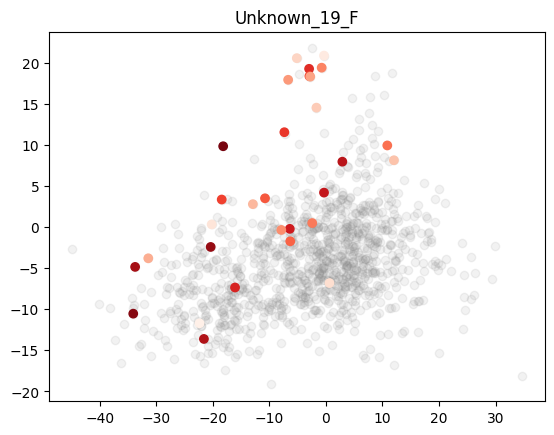

In [47]:
for _roi in ROI_LIST:
    scores = tut.landscape(dat, _roi)
    order = np.argsort(scores)[::-1]
    
    top_k = all_ks[_roi][0]
    print(f'{_roi} top images: {order[:10]}')
    print(f'optimal k-value: {top_k}')
    
    top_imgs = Xz[order[:top_k], :]
    Ztop = pca.transform(top_imgs)
    fig,ax = plt.subplots(1,1)
    ax.scatter(Zall[:, 0], Zall[:, 1], color='gray', alpha=0.1)
    ax.scatter(Ztop[:, 0], Ztop[:, 1], color=sns.color_palette('Reds_r', len(Ztop)))
    ax.set_title(f'{_roi}')
    plt.show()
    
    break
    
    

/tmp/ipykernel_582779/221506731.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Zdf.iloc[order[:top_k]]['is_localizer'] = 2
/tmp/ipykernel_582779/221506731.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Zdf.iloc[order[:top_k]]['is_localizer'] = 2
/tmp/ipykernel_582779/221506731.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

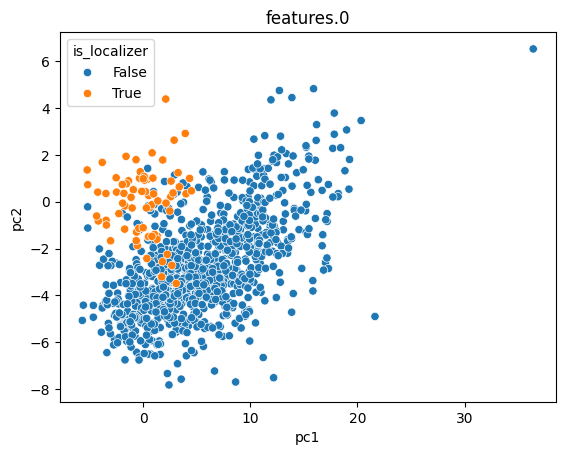

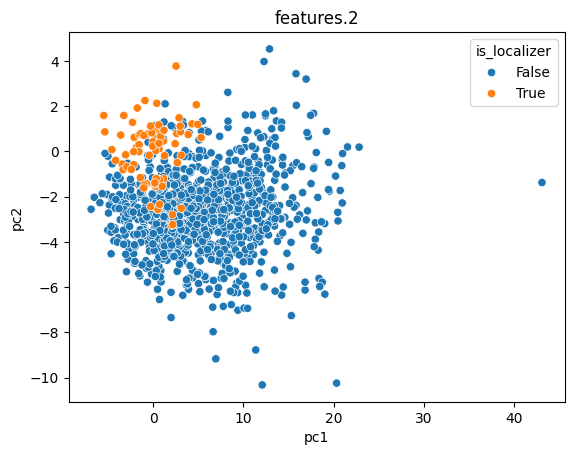

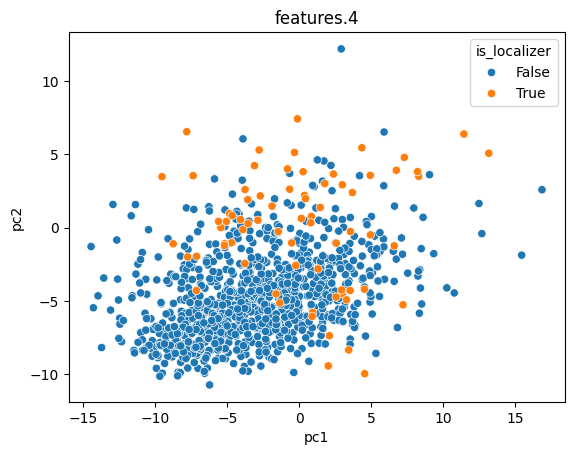

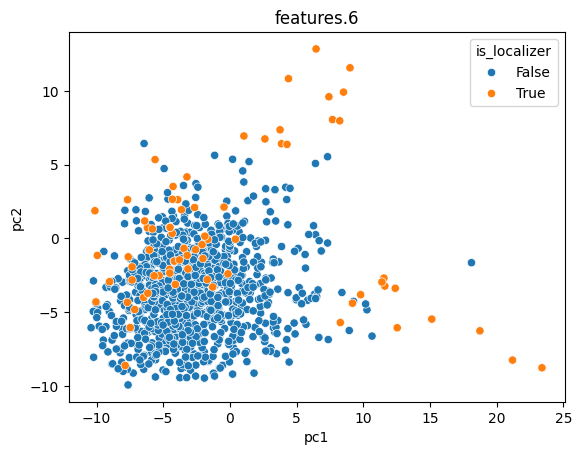

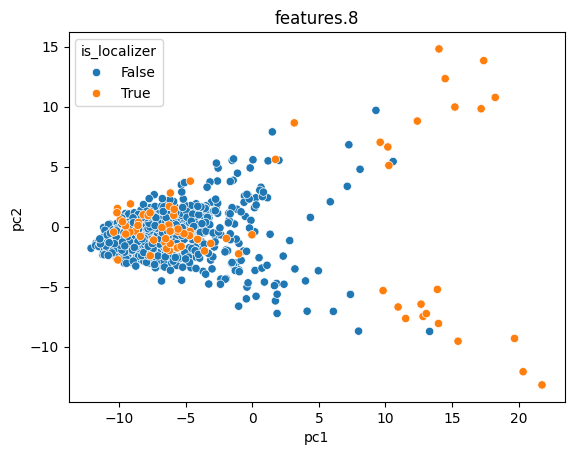

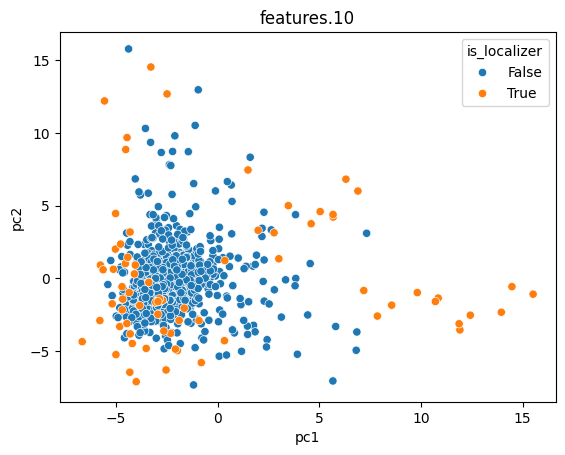

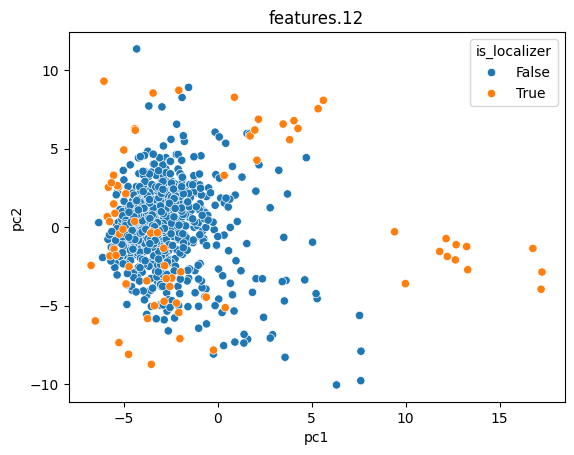

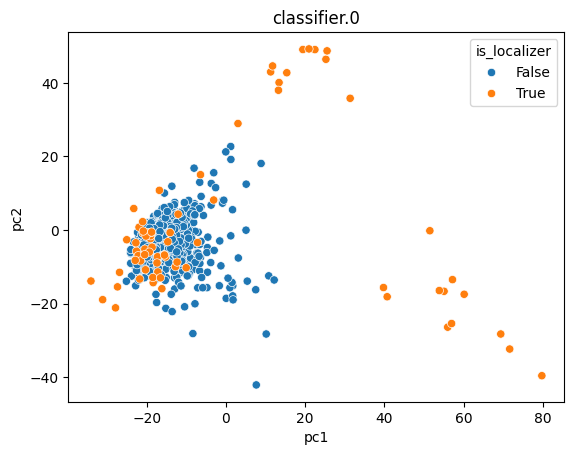

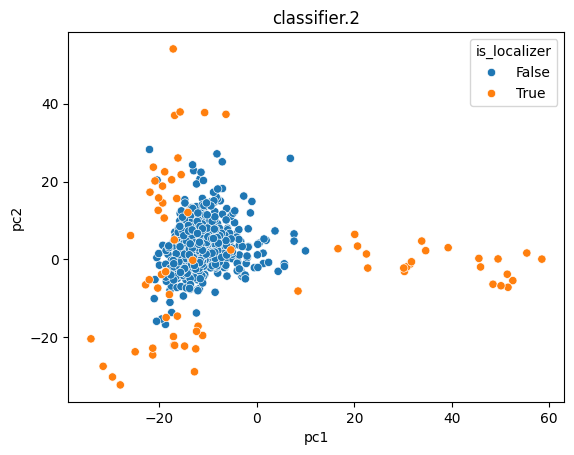

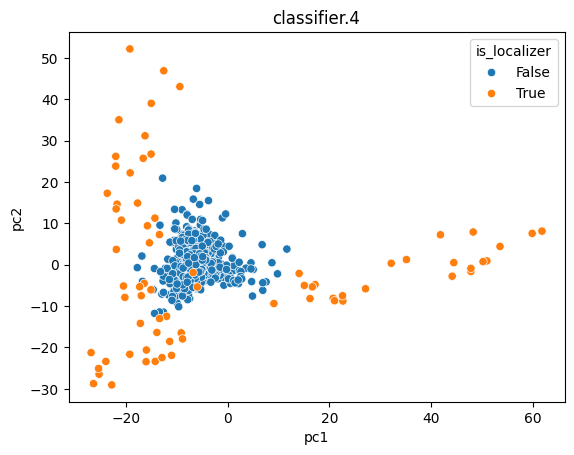

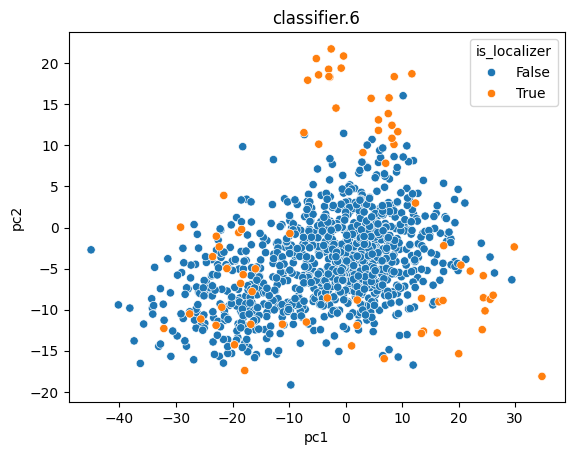

In [49]:
for layer, out in acts.items():
    if len(layer.split('.')) < 2 or int(layer.split('.')[1])%2!=0:
        continue
    # average over all dims beyond the first two
    if out.ndim > 2:
        X = out.mean(dim=tuple(range(2, out.ndim)))
    else:
        X = out
        
    X = X.detach().cpu().numpy()
    ##### z-score the data (based on all images)
    mu = X.mean(axis=0, keepdims=True)          # per-unit mean
    sd = X.std(axis=0, keepdims=True, ddof=1)   # per-unit std (unbiased)

    Xz = (X - mu) / (sd + 1e-8)
    
    # split 
    X72 = Xz[1000:]          # basis-defining set
    Xall = Xz              # everything to project

    # fit pca on last 72 only
    pca = PCA(n_components=2, svd_solver='full')
    pca.fit(X72)

    # project all images into that space
    Zall = pca.transform(Xall)    # [1072, 2]
    Z72  = Zall[1000:]              # same points, highlighted
    
    # fit pca on last 72 only
    pca = PCA(n_components=2, svd_solver='full')
    pca.fit(X72)

    # project all images into that space
    Zall = pca.transform(Xall)    # [1072, 2]
    Z72  = Zall[1000:]              # same points, highlighted

    ######### move to dataframe for plotting
    # assume Zall is [1072, 2]
    n = Zall.shape[0]
    idx = np.arange(n)
    is_localizer = idx >= 1000
    

    Zdf = pd.DataFrame({
        'pc1': Zall[:, 0],
        'pc2': Zall[:, 1],
        'is_localizer': is_localizer,
        'localizer_rank': np.where(is_localizer, idx - 1000, np.nan),  # 0..71 for last 72
    })
       ##### top images for a specific ROI
    top_k = all_ks[_roi][0]
    Zdf.iloc[order[:top_k]]['is_localizer'] = 2
    
    fig,ax = plt.subplots(1,1)
    sns.scatterplot(Zdf, x='pc1', y='pc2', hue='is_localizer', ax=ax)
    ax.set_title(f'{layer}')